In [199]:
import numpy as np
import scanpy as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os
import gseapy
from sklearn import preprocessing


from ete3 import Tree

import pickle as pic

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm

import utilities.de_utils as de_utils
from rpy2.robjects import pandas2ri
import anndata2ri

import rpy2
import logging 


from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
from scvi.dataset import AnnDatasetFromAnnData

import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')
from matplotlib import gridspec



In [200]:
import scvi
scvi.__path__

['/home/eecs/mattjones/.local/lib/python3.6/site-packages/scvi']

## Read in and process data

In [201]:
path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/"
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

adata.var_names = [x.upper() for x in adata.var_names]

all_genes = adata.var_names

meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col=0)
latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0)
latent.index = adata.obs_names

gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values
adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


((43423, 33694), (43423, 10), (40969, 8))

In [202]:
ts_rna_overlap = np.intersect1d(adata.obs_names, meta.index)
len(ts_rna_overlap), len(adata.obs_names), len(meta.index)

(37814, 43423, 40969)

In [203]:
meta_filter = np.logical_not(meta["DynamicMetScore"].isna())
meta = meta.loc[meta_filter]


ts_rna_overlap = np.intersect1d(adata.obs_names, meta.index)
meta = meta.loc[ts_rna_overlap]
adata = adata[ts_rna_overlap,:]

adata.shape

(35006, 33694)

In [204]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['nUMI'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")

meta_filter = np.logical_not(adata.obs["DynamicMetScore"].isna())
adata = adata[meta_filter,:]

latent = latent.loc[adata.obs_names].values

Trying to set attribute `.obs` of view, making a copy.


In [205]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))
sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

Trying to set attribute `.obs` of view, making a copy.


In [206]:
adata = adata[adata.obs.percent_mito <= 0.20, :]

In [207]:
# filter out genes not expressed in at least 1% of cells
thresh = 0.01*adata.shape[0]

sc.pp.filter_genes(adata, min_cells=thresh)

Trying to set attribute `.var` of view, making a copy.


In [208]:
adata.raw = adata

In [209]:
sc.pp.log1p(adata)

In [12]:
# get highly or lowly metastati clones

top_perc = np.percentile(adata.obs['DynamicMetScore'], 90)
bot_perc = np.percentile(adata.obs['DynamicMetScore'], 10)

met_filter = adata.obs.apply(lambda x: x.DynamicMetScore >= top_perc or x.DynamicMetScore <= bot_perc, axis=1)
adata_met = adata[met_filter,:]

## Perform DE analyses 

### LL only samples

In [226]:
adata_ll = de_utils.filter_data_discrete(adata, 'sampleID', ["LL"])
ll_groups = [29, 46, 78, 94]
adata_ll = de_utils.split_data_discrete(adata_ll, 'LineageGroup', ll_groups)

adata_ll.obs['NonBG'] = adata_ll.obs.apply(lambda x: 'BG' if x.Groupby == "BG" else "FG", axis=1)
# sc.tl.rank_genes_groups(adata_ll, "Groupby", groups=ll_groups, reference="BG", method="wilcoxon", use_raw = True, n_genes = len(adata_ll.var_names), only_positive = False)
sc.tl.rank_genes_groups(adata_ll, "NonBG", groups=["BG"], reference="FG", method="wilcoxon", use_raw = True, n_genes = len(adata_ll.var_names), only_positive = False)

Trying to set attribute `.obs` of view, making a copy.
... storing 'sampleID' as categorical
... storing 'Sample2' as categorical
... storing 'Groupby' as categorical
... storing 'condition' as categorical
... storing 'NonBG' as categorical
... storing 'gene_ids' as categorical


In [215]:
def compute_log2fc(gr, bg, gene, adata):
	
	# g1_filt = adata.obs.apply(lambda x: x[groupby_var] == g, axis=1)
	# bg_filt = adata.obs.apply(lambda x: x[groupby_var] == bg, axis=1)
	
	gene_ii = np.where(adata.raw.var_names == gene)[0][0]
	
	exp_g = np.mean(gr[:,gene_ii]) + 0.01
	exp_bg = np.mean(bg[:,gene_ii]) + 0.01
	
	return np.log2(exp_g / exp_bg)

def create_DE_df(counts, groupby_var, gr, bg, result, method='ttest'):
	
	g_filt = counts.obs.apply(lambda x: x[groupby_var] ==  gr, axis=1).values
	bg_filt = counts.obs.apply(lambda x: x[groupby_var] == bg, axis=1).values
	
	print(counts.X.shape, len(g_filt), g_filt[:10])
	gdata = counts.X[g_filt, :]
	bgdata = counts.X[bg_filt, :]
	
	log2fc = {}
	adj_pvalues = {}
	scores = {}

	if method == 'logreg':
		for gene, score in zip(result['names'][gr], result['scores'][gr]):
			scores[gene] = score
			log2fc[gene] = compute_log2fc(gdata, bgdata, gene, counts)
		
		de_df = pd.DataFrame.from_dict(scores, orient='index', columns=['scores'])
		de_df['gene'] = de_df.index
		de_df['log2fc'] = de_df.index.map(log2fc)
		de_df.index = range(de_df.shape[0])
		return de_df
    	
	for gene, qval, fc in zip(result['names'][gr], result['pvals_adj'][gr], result['logfoldchanges'][gr]):
		#scores[gene] = score
		#log2fc[gene] = compute_log2fc(gdata, bgdata, gene)
		
		adj_pvalues[gene] = qval
		log2fc[gene] = compute_log2fc(gdata, bgdata, gene, counts)
		
	de_df = pd.DataFrame.from_dict(adj_pvalues, orient='index', columns=['qval'])
	de_df['gene'] = de_df.index
	de_df['log2fc'] = de_df.index.map(log2fc)
	de_df.index = range(de_df.shape[0])
	return de_df

In [227]:
result = adata_ll.uns["rank_genes_groups"]
groups = result['names'].dtype.names

bg_ll = create_DE_df(adata_ll, "NonBG", "BG", "FG", result, method='wilcoxon')
# lg29_ll = create_DE_df(adata_ll, "Groupby", "29", "BG", result, method='wilcoxon')
# lg36_ll = create_DE_df(adata_ll, "Groupby", "46", "BG", result, method='wilcoxon')
# lg78_ll = create_DE_df(adata_ll, "Groupby", "78", "BG", result, method='wilcoxon')
# lg94_ll = create_DE_df(adata_ll, "Groupby", "94", "BG", result, method='wilcoxon')

bg_ll.to_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ll_bg.txt", sep='\t')
# lg29_ll.to_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/lg29_ll.txt", sep='\t')
# lg36_ll.to_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/lg36_ll.txt", sep='\t')
# lg78_ll.to_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/lg78_ll.txt", sep='\t')
# lg94_ll.to_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/lg94_ll.txt", sep='\t')

# lg29_ll = lg29_ll[(lg29_ll['qval'] < 0.05) & (np.abs(lg29_ll['log2fc']) > np.log2(1.5))]
# lg36_ll = lg36_ll[(lg36_ll['qval'] < 0.05) & (np.abs(lg36_ll['log2fc']) > np.log2(1.5))]
# lg78_ll = lg78_ll[(lg78_ll['qval'] < 0.05) & (np.abs(lg78_ll['log2fc']) > np.log2(1.5))]
# lg94_ll = lg94_ll[(lg94_ll['qval'] < 0.05) & (np.abs(lg94_ll['log2fc']) > np.log2(1.5))]

lg29_lls = lg29_ll[(np.abs(lg29_ll['log2fc']) > np.log2(1.5))]
lg36_lls = lg36_ll[(np.abs(lg36_ll['log2fc']) > np.log2(1.5))]
lg78_lls = lg78_ll[(np.abs(lg78_ll['log2fc']) > np.log2(1.5))]
lg94_lls = lg94_ll[(np.abs(lg94_ll['log2fc']) > np.log2(1.5))]


unique_genes = de_utils.consolidate_genes([lg29_lls, lg36_lls, lg78_lls, lg94_lls])

ll_de_bulk = de_utils.bulk_by_group(adata_ll.obs['Groupby'], adata_ll, unique_genes)

(1867, 12256) 1867 [False  True  True False  True  True  True  True  True  True]


100%|██████████| 5/5 [00:00<00:00, 26.56it/s]


In [220]:
lg29_ll[lg29_ll['gene'] == 'REG4']

,qval,gene,log2fc
75,3.145673e-14,REG4,-3.116911


In [ ]:
sns.set(font_scale=0.7)
plt.figure(figsize=(14, 10))
hm = sns.clustermap(ll_de_bulk.T, cmap="RdBu_r", z_score=0, fmt='d')
plt.title("LG Cluster Heatmap")
# plt.savefig("figs/5k_ll_clusterheatmap.pdf")
plt.show()

In [ ]:
ll_de_bulk.head(5)

In [ ]:
sc.set_figure_params(dpi=80, color_map='viridis')

marker_genes = list(ll_de_bulk.T.index.values)
ax = sc.pl.dotplot(adata_ll, marker_genes + ['IFI6'], groupby='Groupby',
              figsize=(12,4),
              standard_scale='var')

In [ ]:
fig = plt.figure(figsize=(10, 4))
clones = [29, 36, 78, 94]
x, y = np.meshgrid(range(len(clones)), range(len(unique_genes)))
axs = gridspec.GridSpec(
        nrows=2,
        ncols=5,
        wspace=0.02,
        hspace=0.04,
        width_ratios=[
            len(x) * 0.35,
            0.8,
            0.2,
            0.5,
            0.25,
        ],
        height_ratios = [0, 10.5],
)

# size = score
# color = log2fc

sizes = 

dot_ax = fig.add_subplot(axs[1, 0])

dot_ax.scatter(y, x)

dot_ax.set_xticks(range(len(y)))
dot_ax.set_xticklabels(unique_genes)

dot_ax.set_yticks(range(len(x[0])))
dot_ax.set_yticklabels(clones)


plt.xticks(rotation=90)

plt.show()

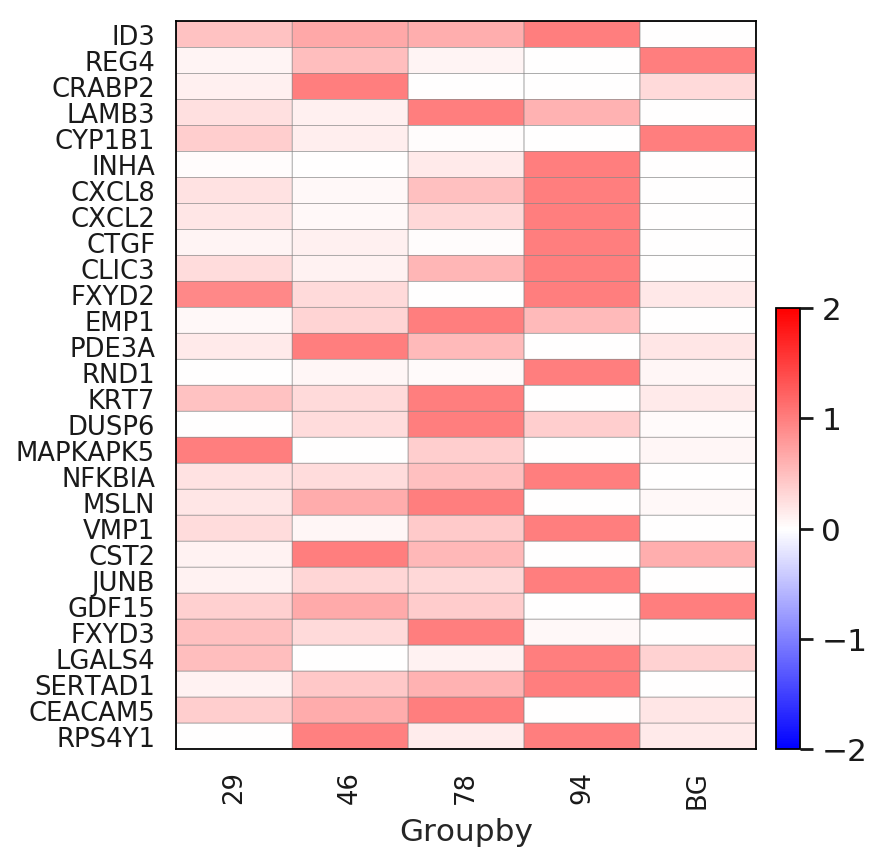

In [94]:
gs = sc.pl.matrixplot(adata_ll, ll_de_bulk.columns, groupby='Groupby', dendrogram=False,
                      use_raw=False, log=True, vmin = -2, vmax=2, cmap='bwr',  swap_axes=True, figsize=(5,6), standard_scale='var')